In [1]:
# ===========================
# Part 1: Setup and Installation
# ===========================

!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn datasets

# Mount Google Drive to save the model
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Step 2: Install Kaggle
!pip install kaggle -q

# Step 3: Setup Kaggle credentials
# Make sure you have uploaded kaggle.json to your Google Drive first
# Download it from: https://www.kaggle.com/settings -> API -> Create New Token

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify setup
!ls ~/.kaggle

print("✓ Kaggle authentication setup complete!")

# Step 4: Download and extract dataset
!kaggle datasets download -d infamouscoder/depression-reddit-cleaned
!unzip -q depression-reddit-cleaned.zip

print("\n✓ Dataset downloaded and extracted!")

# Step 5: List files to find the CSV
import os
files = os.listdir('.')
csv_files = [f for f in files if f.endswith('.csv')]
print(f"\nCSV files found: {csv_files}")

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
✓ Kaggle authentication setup complete!
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open depression-reddit-cleaned.zip, depression-reddit-cleaned.zip.zip 

In [7]:
# Part 2: Authenticate with Kaggle
# ===========================

print("=" * 60)
print("KAGGLE AUTHENTICATION")
print("=" * 60)

# Method 1: Interactive login (easiest for Colab)
try:
    kagglehub.login()
    print("✓ Authentication successful!")
except Exception as e:
    print(f"Interactive login failed: {e}")
    print("\nTrying alternative authentication methods...\n")

    # Method 2: Using kaggle.json from Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    import json

    # Copy kaggle.json from Google Drive to the expected location
    # First, upload your kaggle.json to Google Drive
    kaggle_json_path = '/content/drive/MyDrive/kaggle.json'  # Adjust path if needed

    if os.path.exists(kaggle_json_path):
        !mkdir -p ~/.kaggle
        !cp {kaggle_json_path} ~/.kaggle/kaggle.json
        !chmod 600 ~/.kaggle/kaggle.json
        print("✓ Kaggle credentials loaded from Google Drive!")
    else:
        # Method 3: Manual credential input
        print("\n📝 Manual Setup Required:")
        print("1. Go to https://www.kaggle.com/settings")
        print("2. Scroll to 'API' section")
        print("3. Click 'Create New Token'")
        print("4. Upload the downloaded kaggle.json file below:\n")

        from google.colab import files
        uploaded = files.upload()

        if 'kaggle.json' in uploaded:
            !mkdir -p ~/.kaggle
            with open('/root/.kaggle/kaggle.json', 'w') as f:
                f.write(uploaded['kaggle.json'].decode())
            !chmod 600 ~/.kaggle/kaggle.json
            print("✓ Credentials uploaded successfully!")


KAGGLE AUTHENTICATION
Interactive login failed: name 'kagglehub' is not defined

Trying alternative authentication methods...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📝 Manual Setup Required:
1. Go to https://www.kaggle.com/settings
2. Scroll to 'API' section
3. Click 'Create New Token'
4. Upload the downloaded kaggle.json file below:



Saving depression.zip to depression.zip


In [8]:
from google.colab import drive
import pandas as pd
import numpy as np
import zipfile
import os

# Mount Drive
drive.mount('/content/drive')

print("=" * 60)
print("DATASET LOADING")
print("=" * 60)

# Since you already have depression.zip, let's extract it
print("\n✓ Found depression.zip")

# Extract the zip file
with zipfile.ZipFile('depression.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
    print("✓ Extracted dataset files")

# Find CSV files
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
print(f"\n✓ Found CSV files: {csv_files}")

# Load the dataset
if csv_files:
    df = pd.read_csv(csv_files[0])
    print(f"\n✓ Loaded: {csv_files[0]}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
else:
    print("❌ No CSV files found. Please check the zip contents.")

# Display first few rows
print("\nFirst few rows:")
print(df.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET LOADING

✓ Found depression.zip
✓ Extracted dataset files

✓ Found CSV files: ['depression_dataset_reddit_cleaned.csv']

✓ Loaded: depression_dataset_reddit_cleaned.csv
Shape: (7731, 2)
Columns: ['clean_text', 'is_depression']

First few rows:
                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1


In [10]:

!pip install transformers torch scikit-learn matplotlib seaborn -q

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")



✓ Using device: cuda


In [11]:
# Data Preprocessing
# ===========================

print("\n" + "=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Clean data
df = df.dropna()

# Find text and label columns
print(f"\nDataset columns: {df.columns.tolist()}")

# Common column name patterns
text_cols = ['text', 'clean_text', 'post', 'content', 'message']
label_cols = ['label', 'is_depression', 'class', 'target', 'sentiment']

text_col = None
label_col = None

for col in text_cols:
    if col in df.columns:
        text_col = col
        break

for col in label_cols:
    if col in df.columns:
        label_col = col
        break

# If not found, use first two columns
if text_col is None:
    text_col = df.columns[0]
if label_col is None:
    label_col = df.columns[1]

print(f"\nUsing text column: '{text_col}'")
print(f"Using label column: '{label_col}'")

# Rename columns
df = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'})

# Convert labels to binary (0 and 1)
df['label'] = df['label'].astype(int)

# Remove short texts
df = df[df['text'].str.len() > 20]

print(f"\nCleaned dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSample texts:")
for i in range(min(3, len(df))):
    print(f"\n{i+1}. Text: {df.iloc[i]['text'][:100]}...")
    print(f"   Label: {df.iloc[i]['label']}")

# Balance dataset
from sklearn.utils import resample

pos = df[df['label'] == 1]
neg = df[df['label'] == 0]

print(f"\nOriginal distribution:")
print(f"  Positive (Depression): {len(pos)}")
print(f"  Negative (Non-Depression): {len(neg)}")

# Limit samples for faster training (optional)
MAX_SAMPLES = 5000  # Adjust based on your needs

min_samples = min(len(pos), len(neg), MAX_SAMPLES)

pos_balanced = resample(pos, n_samples=min_samples, random_state=42, replace=False)
neg_balanced = resample(neg, n_samples=min_samples, random_state=42, replace=False)

df_balanced = pd.concat([pos_balanced, neg_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✓ Balanced dataset: {df_balanced.shape}")
print(f"Final distribution:\n{df_balanced['label'].value_counts()}")

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_balanced['text'].values,
    df_balanced['label'].values,
    test_size=0.3,
    random_state=42,
    stratify=df_balanced['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\n✓ Data split complete:")
print(f"  Train: {len(train_texts)}")
print(f"  Validation: {len(val_texts)}")
print(f"  Test: {len(test_texts)}")



DATA PREPROCESSING

Dataset columns: ['clean_text', 'is_depression']

Using text column: 'clean_text'
Using label column: 'is_depression'

Cleaned dataset shape: (7448, 2)

Label distribution:
label
1    3787
0    3661
Name: count, dtype: int64

Sample texts:

1. Text: we understand that most people who reply immediately to an op with an invitation to talk privately m...
   Label: 1

2. Text: welcome to r depression s check in post a place to take a moment and share what is going on and how ...
   Label: 1

3. Text: anyone else instead of sleeping more when depressed stay up all night to avoid the next day from com...
   Label: 1

Original distribution:
  Positive (Depression): 3787
  Negative (Non-Depression): 3661

✓ Balanced dataset: (7322, 2)
Final distribution:
label
0    3661
1    3661
Name: count, dtype: int64

✓ Data split complete:
  Train: 5125
  Validation: 1098
  Test: 1099


In [12]:
# Dataset Class
# ===========================

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [15]:

# ===========================

class BERTBiLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=256,
                 lstm_layers=2, num_classes=2, dropout=0.3):
        super(BERTBiLSTMClassifier, self).__init__()

        # BERT embeddings
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_dim = self.bert.config.hidden_size  # 768

        # Freeze BERT (for faster training)
        for param in self.bert.parameters():
            param.requires_grad = False

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=self.bert_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Classification layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def attention_net(self, lstm_output):
        attention_weights = torch.tanh(self.attention(lstm_output))
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_output = lstm_output * attention_weights
        return torch.sum(weighted_output, dim=1)

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state

        # Pass through BiLSTM
        lstm_output, _ = self.lstm(sequence_output)

        # Apply attention
        attended_output = self.attention_net(lstm_output)

        # Classification
        x = self.dropout(attended_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

In [16]:
#  Initialize Model
# ===========================

print("\n" + "=" * 60)
print("MODEL INITIALIZATION")
print("=" * 60)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BERTBiLSTMClassifier().to(device)

BATCH_SIZE = 16

train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer)
val_dataset = MentalHealthDataset(val_texts, val_labels, tokenizer)
test_dataset = MentalHealthDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model Architecture: BERT + BiLSTM + Attention")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Learning rate: 2e-5")


MODEL INITIALIZATION


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


✓ Model Architecture: BERT + BiLSTM + Attention
✓ Total parameters: 113,292,803
✓ Trainable parameters: 3,810,563
✓ Batch size: 16
✓ Learning rate: 2e-5


In [18]:
# Training Functions
# ===========================

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    losses = []
    correct = 0
    total = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    return correct / total, np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    return correct / total, np.mean(losses), all_preds, all_labels, all_probs

# ===========================

In [20]:
#  Train Model
# ===========================

print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

EPOCHS = 5
best_val_acc = 0
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f'\n{"="*60}')
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print("="*60)

    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss, _, _, _ = eval_model(model, val_loader, criterion, device)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f'\n📊 Results:')
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/mental_health_model.pth')
        print(f'  ✓ Model saved! (Best Val Acc: {val_acc*100:.2f}%)')

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"✓ Best Validation Accuracy: {best_val_acc*100:.2f}%")


TRAINING

Epoch 1/5


Evaluating: 100%|██████████| 69/69 [00:08<00:00,  7.82it/s]



📊 Results:
  Train Loss: 0.3695 | Train Acc: 87.69%
  Val Loss: 0.1986 | Val Acc: 92.17%
  ✓ Model saved! (Best Val Acc: 92.17%)

Epoch 2/5


Evaluating: 100%|██████████| 69/69 [00:11<00:00,  5.86it/s]



📊 Results:
  Train Loss: 0.1475 | Train Acc: 94.56%
  Val Loss: 0.1528 | Val Acc: 94.54%
  ✓ Model saved! (Best Val Acc: 94.54%)

Epoch 3/5


Evaluating: 100%|██████████| 69/69 [00:09<00:00,  7.36it/s]



📊 Results:
  Train Loss: 0.1256 | Train Acc: 95.40%
  Val Loss: 0.1403 | Val Acc: 95.36%
  ✓ Model saved! (Best Val Acc: 95.36%)

Epoch 4/5


Evaluating: 100%|██████████| 69/69 [00:11<00:00,  6.23it/s]



📊 Results:
  Train Loss: 0.1110 | Train Acc: 96.04%
  Val Loss: 0.1193 | Val Acc: 96.08%
  ✓ Model saved! (Best Val Acc: 96.08%)

Epoch 5/5


Evaluating: 100%|██████████| 69/69 [00:09<00:00,  7.31it/s]


📊 Results:
  Train Loss: 0.0986 | Train Acc: 96.33%
  Val Loss: 0.1157 | Val Acc: 96.08%

TRAINING COMPLETE!
✓ Best Validation Accuracy: 96.08%



MODEL EVALUATION


Evaluating: 100%|██████████| 69/69 [00:10<00:00,  6.80it/s]



📊 Test Results:
  Accuracy: 94.54%
  Loss: 0.1427

CLASSIFICATION REPORT
                precision    recall  f1-score   support

Non-Depression     0.9471    0.9436    0.9454       550
    Depression     0.9437    0.9472    0.9455       549

      accuracy                         0.9454      1099
     macro avg     0.9454    0.9454    0.9454      1099
  weighted avg     0.9454    0.9454    0.9454      1099


DETAILED METRICS
Precision:          0.9437
Recall:             0.9472
F1 Score (Binary):  0.9455
F1 Score (Weighted):0.9454
F1 Score (Macro):   0.9454
ROC-AUC Score:      0.9878
Matthews Corr Coef: 0.8908

CONFUSION MATRIX
True Negatives:  519
False Positives: 31
False Negatives: 29
True Positives:  520


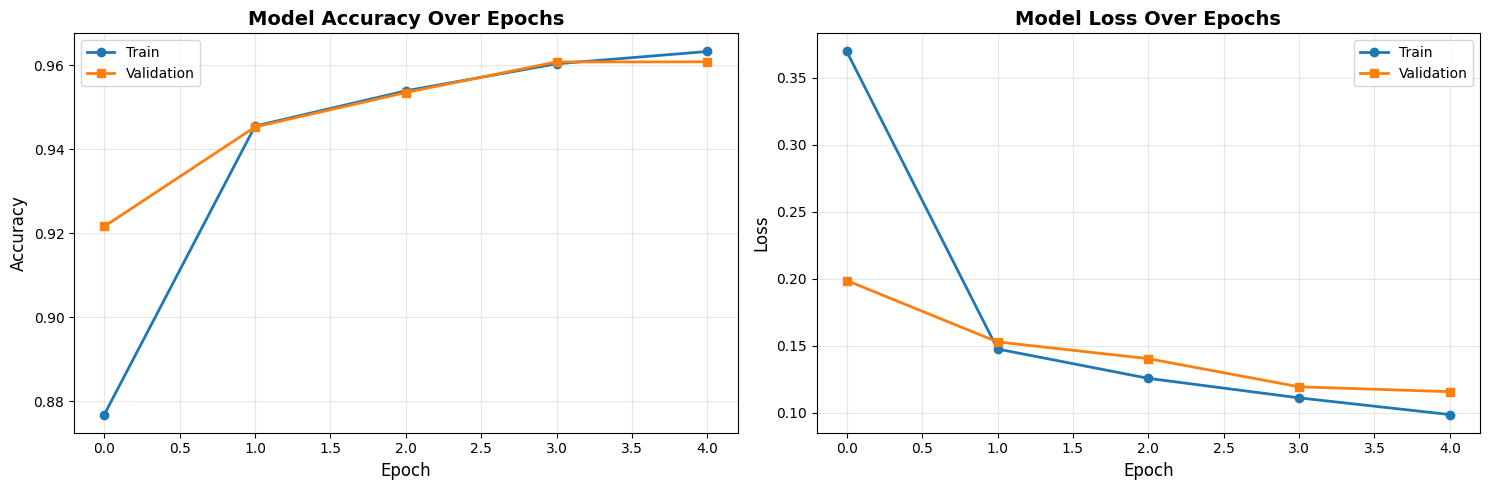

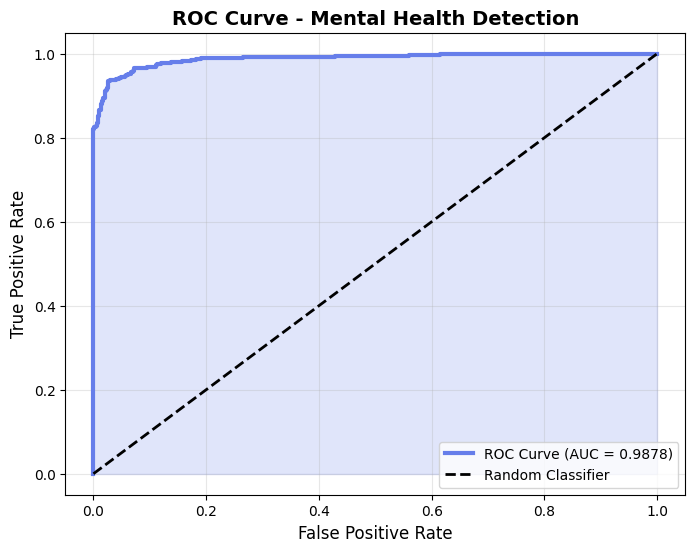

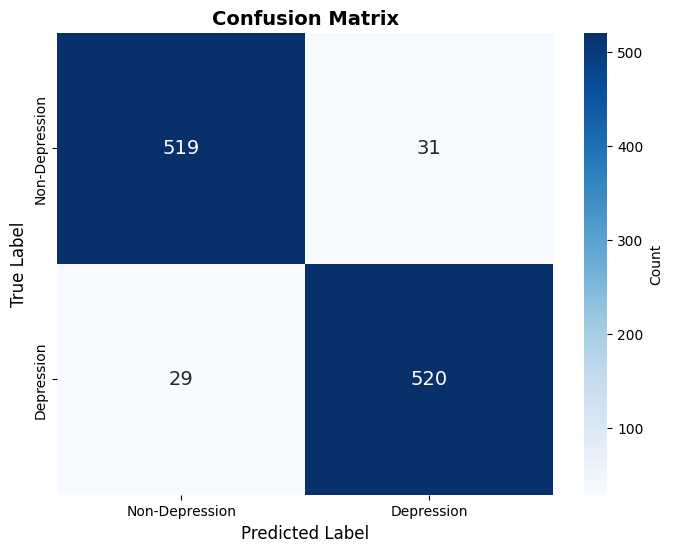

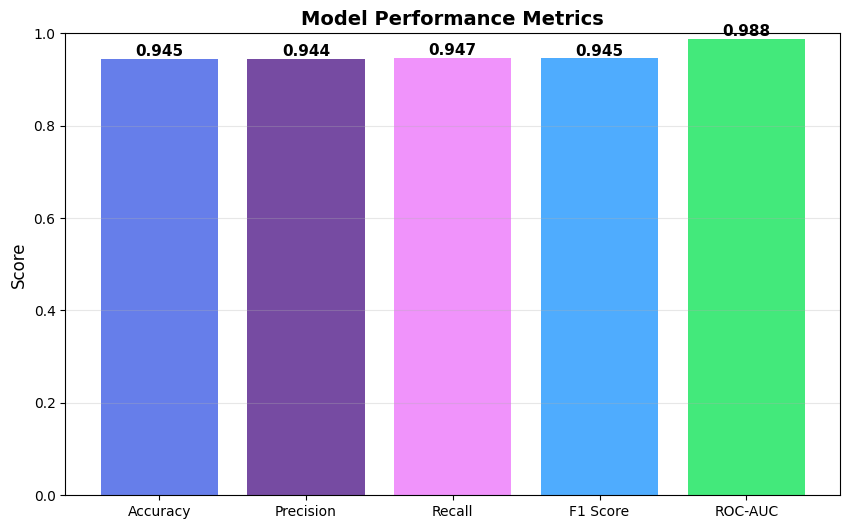


SAVING MODEL FILES
✓ Tokenizer saved
✓ Model config saved
✓ Metrics saved

✓ ALL FILES SAVED TO GOOGLE DRIVE!

Saved files:
1. mental_health_model.pth - Model weights
2. mental_health_tokenizer/ - BERT tokenizer
3. model_config.json - Model configuration
4. model_metrics.json - Performance metrics
5. training_history.png - Training curves
6. roc_curve.png - ROC curve
7. confusion_matrix.png - Confusion matrix
8. metrics_comparison.png - Metrics comparison

TEST PREDICTIONS

1. Text: I feel so hopeless and empty. Nothing makes me happy anymore.
   Prediction: 🔴 Depression/Stress Detected
   Confidence: 82.6%
   Probabilities: Non-Depression=0.174, Depression=0.826

2. Text: Had a wonderful day today! Life is beautiful!
   Prediction: 🟢 No Signs Detected
   Confidence: 99.1%
   Probabilities: Non-Depression=0.991, Depression=0.009

3. Text: I can't sleep. My mind won't stop racing with anxious thoughts.
   Prediction: 🔴 Depression/Stress Detected
   Confidence: 56.2%
   Probabilities: N

In [21]:
# ===========================
# COMPLETE EVALUATION & METRICS
# ===========================

print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/mental_health_model.pth'))

# Evaluate on test set
test_acc, test_loss, test_preds, test_labels, test_probs = eval_model(
    model, test_loader, criterion, device
)

print(f'\n📊 Test Results:')
print(f'  Accuracy: {test_acc*100:.2f}%')
print(f'  Loss: {test_loss:.4f}')

# ===========================
# DETAILED METRICS
# ===========================

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef
)

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    test_labels,
    test_preds,
    target_names=['Non-Depression', 'Depression'],
    digits=4
))

# Calculate all metrics
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
f1_weighted = f1_score(test_labels, test_preds, average='weighted')
f1_macro = f1_score(test_labels, test_preds, average='macro')
roc_auc = roc_auc_score(test_labels, test_probs)
mcc = matthews_corrcoef(test_labels, test_preds)

print("\n" + "=" * 60)
print("DETAILED METRICS")
print("=" * 60)
print(f'Precision:          {precision:.4f}')
print(f'Recall:             {recall:.4f}')
print(f'F1 Score (Binary):  {f1:.4f}')
print(f'F1 Score (Weighted):{f1_weighted:.4f}')
print(f'F1 Score (Macro):   {f1_macro:.4f}')
print(f'ROC-AUC Score:      {roc_auc:.4f}')
print(f'Matthews Corr Coef: {mcc:.4f}')

# ===========================
# CONFUSION MATRIX
# ===========================

cm = confusion_matrix(test_labels, test_preds)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print(f'True Negatives:  {cm[0][0]}')
print(f'False Positives: {cm[0][1]}')
print(f'False Negatives: {cm[1][0]}')
print(f'True Positives:  {cm[1][1]}')

# ===========================
# VISUALIZATIONS
# ===========================

# 1. Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_acc'], label='Train', marker='o', linewidth=2)
axes[0].plot(history['val_acc'], label='Validation', marker='s', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

axes[1].plot(history['train_loss'], label='Train', marker='o', linewidth=2)
axes[1].plot(history['val_loss'], label='Validation', marker='s', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})',
         linewidth=3, color='#667eea')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.fill_between(fpr, tpr, alpha=0.2, color='#667eea')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Mental Health Detection', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('/content/drive/MyDrive/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Depression', 'Depression'],
            yticklabels=['Non-Depression', 'Depression'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Metrics Comparison Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
metrics_values = [test_acc, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#667eea', '#764ba2', '#f093fb', '#4facfe', '#43e97b'])
plt.ylim([0, 1])
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.savefig('/content/drive/MyDrive/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ===========================
# SAVE ALL MODEL FILES
# ===========================

print("\n" + "=" * 60)
print("SAVING MODEL FILES")
print("=" * 60)

# Save tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/mental_health_tokenizer')
print("✓ Tokenizer saved")

# Save model config
import json
model_config = {
    'bert_model_name': 'bert-base-uncased',
    'hidden_dim': 256,
    'lstm_layers': 2,
    'num_classes': 2,
    'dropout': 0.3,
    'max_len': 128,
    'test_accuracy': float(test_acc),
    'f1_score': float(f1),
    'roc_auc': float(roc_auc)
}

with open('/content/drive/MyDrive/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)
print("✓ Model config saved")

# Save metrics
metrics_dict = {
    'accuracy': float(test_acc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'roc_auc': float(roc_auc),
    'matthews_corrcoef': float(mcc),
    'confusion_matrix': cm.tolist()
}

with open('/content/drive/MyDrive/model_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)
print("✓ Metrics saved")

print("\n" + "=" * 60)
print("✓ ALL FILES SAVED TO GOOGLE DRIVE!")
print("=" * 60)
print("\nSaved files:")
print("1. mental_health_model.pth - Model weights")
print("2. mental_health_tokenizer/ - BERT tokenizer")
print("3. model_config.json - Model configuration")
print("4. model_metrics.json - Performance metrics")
print("5. training_history.png - Training curves")
print("6. roc_curve.png - ROC curve")
print("7. confusion_matrix.png - Confusion matrix")
print("8. metrics_comparison.png - Metrics comparison")

# ===========================
# TEST PREDICTION FUNCTION
# ===========================

def predict_mental_health(text, model, tokenizer, device, max_len=128):
    """Predict depression/stress from text"""
    model.eval()

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probs, dim=1)

    return {
        'prediction': int(prediction.item()),
        'confidence': float(confidence.item()),
        'probabilities': {
            'non_depression': float(probs[0][0]),
            'depression': float(probs[0][1])
        }
    }

# Test examples
test_texts = [
    "I feel so hopeless and empty. Nothing makes me happy anymore.",
    "Had a wonderful day today! Life is beautiful!",
    "I can't sleep. My mind won't stop racing with anxious thoughts.",
    "Just finished a great workout! Feeling energized and motivated!"
]

print("\n" + "=" * 60)
print("TEST PREDICTIONS")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    result = predict_mental_health(text, model, tokenizer, device)
    label = "🔴 Depression/Stress Detected" if result['prediction'] == 1 else "🟢 No Signs Detected"

    print(f"\n{i}. Text: {text}")
    print(f"   Prediction: {label}")
    print(f"   Confidence: {result['confidence']*100:.1f}%")
    print(f"   Probabilities: Non-Depression={result['probabilities']['non_depression']:.3f}, "
          f"Depression={result['probabilities']['depression']:.3f}")

print("\n✓ MODEL EVALUATION COMPLETE!")
